# Lecture #5: Monte Carlo Integration
## AM 207: Advanced Scientific Computing
### Stochastic Methods for Data Analysis, Inference and Optimization
### Fall, 2019

<img src="fig/logos.jpg" style="height:150px;">

In [2]:
### Import basic libraries
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
%matplotlib inline

## Administrative Matters

1. **Attendance Quiz:** https://tinyurl.com/y6kj7lhb<br><br>

## Outline
1. Review of Samplers for Posterior Simulation
2. Basics of Monte Carlo Simulation
3. Variance Reduction: Control Variates
4. Variance Reduction: Stratified Sampling
5. Variance Reduction: Importance Sampling
6. Application: Monte Carlo Estimation of Arbitrary Integrals

# Review of Samplers for Posterior Simulation

## Samplers for Simulating Random Variables
A ***sampler*** is a procedure for producing random numbers from a specific distribution $p(X)$. We've seen that we can build up samplers for sophisticated distributions, incrementally, starting from a sampler for a uniform distribution $U(0, 1)$.

1. **Linear Congruence Pseudo Random Number Generator:** simulates random numbers in $U(0, 1)$. 
  By translating and scaling we can simulate a random variable $U\sim U(a, b)$.
  
2. **Inverse CDF Sampling:** transforms random samples from a uniform distribution $U(0, 1)$ into samples from a univariate distribution $p(X)$ by using the inverse CDF of $X$. 
  
3. **Rejection Sampling:** find a proposal distribution $q(X)$ that is (1) easy to sample from and (2) approximates the target distribution $p(X)$. We then sample from $q$ and reject samples that are unlikely under $p$.
  
4. **Gibbs Sampling:** when complex multivariate distributions have easy conditional distributions $p(X_n | X_1, \ldots, X_{n-1}, X_{n+1}, \ldots, X_{N})$, we can obtain samples iteratively by updating the last sample from the conditionals, one coordinate at a time. *Eventually, these samples will be from $p(X)$*. This allows us to sample from the posterior of models with semi-conjugate priors.  

## Semi-Conjugate Priors

Let $Y \sim \mathcal{N}(\mu, \sigma^2)$, with both parameters unknown. We place a normal prior on $\mu$, $\mu\sim\mathcal{N}(m, s^2)$, and an gamma prior on $\sigma^2$, $\sigma^2\sim IG(\alpha, \beta)$.

The posterior $p(\mu, \sigma^2|Y)$ is then:

\begin{aligned}
p(\mu, \sigma^2 | Y)  = \frac{\overbrace{\frac{1}{\sqrt{2\pi \sigma^2}} \mathrm{exp} \left\{-\frac{(Y - \mu)^2}{2\sigma^2}\right\}}^{\text{likelihood}} \overbrace{\frac{1}{\sqrt{2\pi s^2}} \mathrm{exp} \left\{-\frac{(m - \mu)^2}{2s^2}\right\}}^{\text{prior on $\mu$}}\overbrace{\frac{\beta^\alpha}{\Gamma(\alpha)} \left( \sigma^2\right)^{-\alpha -1}\mathrm{exp} \left\{-\frac{\beta}{\sigma^2}\right\}}^{\text{prior on $\sigma^2$}}}{p(Y)}
\end{aligned}

Note that:

1. if we condition on $\sigma^2$ (i.e. hold it constant) then $p(\mu| Y, \sigma^2)$ is a normal pdf, $\mathcal{N}\left(\mu; \frac{s^2y + \sigma^2m}{s^2 + \sigma^2}, s^2\sigma^2\right)$.
2. if we condition on $\mu$ (i.e. hold it constant) then $p(\sigma^2| Y, \mu)$ is an inverse gamma pdf, $IG\left(\sigma^2; \alpha + 0.5, \frac{(y-\mu)^2}{2} + \beta\right)$

That is, **the conditional of the posterior are easy to sample from while the joint posterior is not**. In this case, we call the priors ***semi-conjugate*** for our likelihood.

## Gibbs Sampling: An Intuition
If we start at a point $(x^{(0)}, y^{(0)})$ sampled from from the joint distribution $p(X, Y)$, we can get to the next point $(x^{(1)}, y^{(1)}) \sim p(X, Y)$ through a "stepping-stone" $(x^{(1)}, y^{(0)})$, where we updated the first coordinate by $x^{(1)} \sim p(X|Y = y^{(0)})$. From there, we update the second coordinate $y^{(1)} \sim p(Y|X = x^{(1)})$.

The initial samples may be unlikely under $p(X, Y)$, but this process will eventually lead us to a high density area in $p(X, Y)$ and we will mostly sample there.
<img src="fig/gibbs.jpg" style="height:350px">

## Gibbs Sampling: Algorithm

To simulate $N$ samples of a $D$-dimensional multivariate random variable $X$ with pdf $f_X$, we
1. initialization: choose any $x^{(0)} = \left[x^{(0)}_1\;\; \ldots\;\; x^{(0)}_D\right]$
2. iterate $N$ times: sample $x^{(n+1)} = \left[x^{(n+1)}_1\;\; \ldots\;\; x^{(n+1)}_D\right]$ by

  a. initialization: sample $X^{(n+1)}_1$ from the conditional distribution 
  
  $$f_X\left(X_1 \,|\, X_2 = x^{(n)}_2,\;\ldots,\; X_D = x^{(n)}_D\right)$$
  
  b. iterate from $d = 2$ througbh $d=D$: sample $x^{(n+1)}_d$ from the conditional distribution
  
  $$f_X\left(X_d \,|\, X_1 = x^{(n+1)}_1,\; \ldots,\; X_{d-1} = x^{(n+1)}_{d-1},\; X_{d+1} = x^{(n)}_{d+1},\; \ldots,\; X_D = x^{(n)}_D\right)$$
  
**Claim:** When $N$ is large enough, the latter portion of the samples we obtain will be from the distribution of $X$.
  
**Question:** Why is this algorithm a valid sampler? That is, how do we prove that the samples we obtain are actually distributed as $f_X$? What is the effect of the initialization $x^{(0)}$?

## Simulating the Posterior of a Normal-Normal-Inverse Gamma Model
Let $Y \sim \mathcal{N}(\mu, \sigma^2)$, with both parameters unknown. We place a normal prior on $\mu$, $\mu\sim\mathcal{N}(m, s^2)$, and an gamma prior on $\sigma^2$, $\sigma^2\sim IG(\alpha, \beta)$.

1. $p(\mu| Y, \sigma^2)$ is a normal pdf, 
$$\mathcal{N}\left(\mu; \frac{s^2y + \sigma^2m}{s^2 + \sigma^2}, s^2\sigma^2\right).$$
2. $p(\sigma^2| Y, \mu)$ is an inverse gamma pdf, 
$$IG\left(\sigma^2; \alpha + 0.5, \frac{(y-\mu)^2}{2} + \beta\right).$$

We choose an arbitrary initial point $(\mu_0, \sigma^2_0) \in \mathbb{R}^2$, and then sample the next point by  sampling from the conditionals $p(\mu| Y, \sigma^2)$ and $p(\sigma^2| Y, \mu)$, in order.

In [2]:
#total number of gibbs samples
N = 1000
#observation
y = 1.
#inverse gamma prior
alpha = 2.
beta = 3.
#normal prior
s = 1.
m = 2.

#initialize the gibbs sampler
current_mu = 0.
current_sigma_sq = 1. 
posterior_samples = [(current_mu, current_sigma_sq)]

#run gibbs N times
for n in range(N):
    #sample mu from the posterior conditioned on the current sigma squared
    next_mu = np.random.normal((s**2 * y) / (s**2 + current_sigma_sq), s**2 * current_sigma_sq)
    #sample sigma squared from the posterior conditioned on the updated mu
    next_sigma_sq = sp.stats.invgamma.rvs(alpha + 0.5, scale=1. / ((y - next_mu)**2 / 2. + beta), size=1)
    #the next sample is the updated mu and sigma squared
    current_mu = (next_mu, next_sigma_sq)
    posterior_samples.append(current_mu)
    
posterior_samples = np.array(posterior_samples)[100:, :]

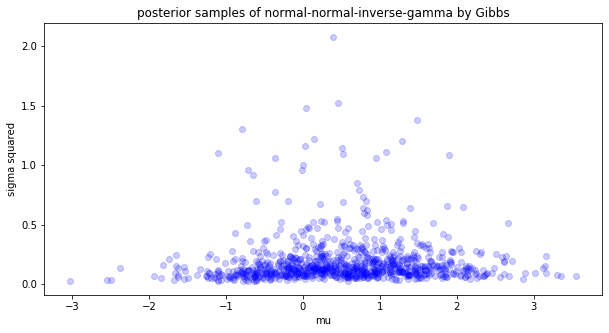

In [3]:
#plot posterior samples via gibbs
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x = np.linspace(0, 10, 100)
ax.scatter(posterior_samples[:, 0], posterior_samples[:, 1], color='blue', alpha=0.2)
ax.set_title('posterior samples of normal-normal-inverse-gamma by Gibbs')
ax.set_xlabel('mu')
ax.set_ylabel('sigma squared')
plt.show()   

## How to Evaluate a Sampler

1. **Correctness:** Every sampler must come with a ***proof*** of correctness - that is, the numbers produced by the sampler have the distribution $p(X)$. Many intuitively sensible ways of sampling can fail to be correct.

  **Question:** Why isn't it sufficient to "histogram" the samples and check that they are distributed like $p(X)$?<br><br>

2. **Efficiency:** Every sampler must be analyzed for it's efficiency - that is, how many times the procedure must run before it accepts a sample. You should also be aware of how the efficiency is affected by the dimension of $X$.

  **Question:** How do inverse CDF and rejection compare in terms of efficiency?<br><br>
  
3. **Sufficiency of repetition:** Some samplers like Gibbs comes with the guarantee that if you repeat the procedure enough times (asymptotically), you will eventually be sampling from $p(X)$. But exactly how many times is enough?

## Why are We Sampling Again?

Recall that the primary objects of interest in a Bayesian model are the ***posterior distribution*** over parameters and the ***posterior predictive distribution*** over observations.

Evaluating the model, forming scientific hypothesis about the data and making predictions all require **sampling** from one of the two distributions.

When the prior is conjugate for the likelihood, the posterior pdf can be derived in closed form. Often, such a posterior is easy to sample from (using inverse CDF or rejection sampling). However, restricting ourselves to such simple likelihoods and priors limits our ability to model complex real-life data!

Our goal is to develop a set of different procedures that allow us to sample from arbitrary distributions. I.e. **samplers will make Bayesian inference more "generic", less "artisenal"**.

## What If We Want Posterior Point Estimates?

Posterior samples allow us to approximately compute posterior point estimates, for example, we can approximate the posterior mean as
$$
\mathbb{E}_{\theta|Y}[\theta] = \int_\Theta \theta\, p(\theta | Y)\,d\theta \approx \frac{1}{S}\sum_{s=1}^S \theta_s,\, \theta_s \sim p(\theta | Y)
$$

In fact, for any function $f$ of $\theta | Y$, we can estimate the expected vaue of $f$ by first sampling $S$ samples from the posterior $p(\theta | Y)$ and then compute the average value of $f$ on these samples:
$$
\mathbb{E}_{\theta|Y}[f(\theta)] = \int_\Theta f(\theta)\, p(\theta | Y)\,d\theta \approx \frac{1}{S}\sum_{s=1}^S f(\theta_s),\, \theta_s \sim p(\theta | Y)
$$

**Question:** But is this estimate consistent? Unbiased? Of minimal variance?

# Basics of Monte Carlo Integration

## Naive Monte Carlo Estimation of Integrals
Let $I$ denote the integral 
$$\mathbb{E}_{\theta|Y}[f(\theta)] = \int_\Theta f(\theta)\, p(\theta | Y)\,d\theta$$ 
and let $\widehat{I}$ denote the approximation 
$$\frac{1}{S}\sum_{s=1}^S f(\theta_s),\, \theta_s \sim p(\theta | Y).$$ 

We call $\widehat{I}$ the ***Monte Carlo estimate*** of $I$. 

In general, ***Monte Carlo integration*** is the process of estimating a deterministic quantity (an integral) using a procedure involving stochasticity (sampling).

## The Consistency and Unbiasedness of Monte Carlo Estimators
Recall that the **Strong Law of Large Numbers** says that the mean of $S$ iid random variables converges to the mean, with probability 1, as $S\to \infty$. This means that 

$$
\lim_{S\to\infty} \frac{1}{S}\sum_{s=1}^S f(\theta_s),\, \theta_s \sim p(\theta | Y) \;= \;\mathbb{E}_{\theta|Y}\left[f(\theta) \right]
$$

with probability 1. Hence, the Monte Carlo Estimator $\widehat{I}$ is ***consistent***.

The expected value of $\widehat{I}$ is

$$
\mathbb{E}_{\theta_S}[\widehat{I}]\, = \, \mathbb{E}_{\theta_S}\left[\frac{1}{S}\sum_{s=1}^S f(\theta_s)\right] = \, \frac{1}{S}\sum_{s=1}^S \mathbb{E}_{\theta_s}\left[f(\theta_s)\right] = \frac{1}{S} \sum_{s=1}^S I = I,
$$

where $\theta_s \sim p(\theta | Y)$. Hence, the Monte Carlo Estimator $\widehat{I}$ is ***unbiased***. 

## The Variance and Error of Monte Carlo Estimators
The variance of $\widehat{I}$ is given by 

$$
\mathrm{Var}\left[ \widehat{I}\right] = \mathrm{Var}\left[\frac{1}{S}\sum_{s=1}^S f(\theta_s)\right] = \frac{1}{S^2} \sum_{s=1}^S \mathrm{Var}\left[ f(\theta_s)\right] = \frac{\mathrm{Var}\left[ f(\theta)\right]}{S}\,,
$$

where $\theta_s, \theta \sim p(\theta | Y)$. Plainly put, **the variance of the estimator is reduced when number of samples $S$ is large and the variance $\sigma^2_f = \mathrm{Var}\left[ f(\theta)\right]$ of $f(\theta)$ is low**.

The **Central Limit Theorem** says that the differnece between sample mean and the theoretical mean of iid random variables will approach a normal distribution as $N \to \infty$. For us, this means that the error of $\widehat{I}$ has a roughly normal distribution:

$$
p\left(\widehat{I} - I\right) \to \mathcal{N}\left(0, \frac{\sigma_f^2}{S}\right)\,,\; S\to \infty
$$

Again, this says that, to reduced the error of $\widehat{I}$ we can increase the number of samples $S$ or decrease the variance $\sigma^2_f$ of $f(\theta)$.

# Variance Reduction: Control Variates

## A Baseline for Variance of Monte Carlo Estimates

The variance of the naive Monte Carlo estimate $\widehat{I}$ is:
\begin{aligned}
\mathrm{Var}\left[ \widehat{I}\right] &= \frac{1}{S}\mathrm{Var}\left[ f(\theta)\right]\\ 
&= \mathbb{E}_{\theta|Y}\left[\left( f(\theta) - \mathbb{E}_{\theta|Y}\left[ f(\theta)\right]\right)^2\right]\\
&= \mathbb{E}_{\theta|Y}\left[ f(\theta)^2 \right] - \mathbb{E}_{\theta|Y}\left[ f(\theta)\right]^2\\
&= \int_\Theta f(\theta)^2 p(\theta|Y)d\theta  - I^2
\end{aligned}

We'll compare the variance of alternative estimator to the above when checking for variance reduction.

**Note:** The variance of $f(\theta)$ depends on *both* the variance of $\theta$ and the amount of variation in the function $f$. **Functions that change a great amount over the domain will have a high variance and functions that are flat will have a low variance.**

## The General Idea of Control Variates
Based on our realization that "flat" functions have lower variance, we will try to engineer "flat" functions that allow use to compute the integral of $f$.

**Observation:** For a given function $f(X)$, if $h$ is a function of $X$ that correlates with $f$, then $f(X)-h(X)$ will have lower variance.

<img src="fig/control.jpg" style="height:350px">

## Variance of Control Variates

Fix a function $f(\theta)$, $\theta\sim p(\theta|Y)$. Let $h(\theta)$ be a function with known mean $\mu_h = \mathbb{E}_{\theta|Y}[h(\theta)]$ and such that $h(\theta)$ is correlated with $f(\theta)$. We call $h$ the ***control variate*** for $f$. 

We define the ***control variate Monte Carlo estimate*** of $\mathbb{E}_{\theta|Y}[f(\theta)]$ to be

$$
\widehat{I}_{\text{control}} = \frac{1}{S}\sum^S_{s=1} f(\theta) - c(h(\theta) - \mu_h)
$$

where $c$ is our choice of a constant. 

The variance of this estimator is:

$$
\sigma^2_{\widehat{I}_{\text{control}}} = \sigma^2_f + c^2 \sigma_h^2 - 2c * \mathbf{cov}[f(\theta), h(\theta)]
$$

Thus, we see that when $\mathbf{cov}[f(\theta), h(\theta)] \neq 0$ there is hope for variance reduction, $\sigma^2_{\widehat{I}_{\text{control}}} < \sigma^2_f$!

**Exercise:** check that $\widehat{I}_{\text{control}}$ is consistent and unbiased! Derive $\sigma^2_{\widehat{I}_{\text{control}}}$!

## The Nitty Gritty of Control Variates

Using control variate Monte Carlo requires that we:
1. choose a control variate $h$ with known mean and who is correlated with $f$.
2. choose a constant $c$.

Typically, we want to choose an $h$ that follows to the trends of $f$ that is easy to integrate.

The value of $c$ that minimizes $\sigma^2_{\widehat{I}_{\text{control}}}$ is 
$$
c^* = \frac{\mathbf{cov}[f(\theta), h(\theta)]}{\sigma_h^2}.
$$

In case $\mathbf{cov}[f(\theta), h(\theta)]^2$ and $\sigma_h^2$ are difficult to compute analytically, they can be empirically estimated from the samples.

When we choose the optimal $c = c^*$, the variance of $\widehat{I}_{\text{control}}$ is

$$
\sigma^2_{\widehat{I}_{\text{control}}} = \left(1 - \frac{\mathbf{cov}[f(\theta), h(\theta)]}{\sigma_h^2\sigma_f^2}\right)\sigma_f^2 \sigma^2_{\widehat{I}_{\text{control}}} = (1 - \rho_{f, h})\sigma_f^2,
$$

where $\rho_{f, h}$ is the correlation between the outputs of $f$ and $h$. Hence, the more $h$ is correlated with the ouput the greater the variance reduction.

## Example: Control Variates

Let $f(\theta) = -0.2 \theta^3 + 100\sin(\theta)$ for $\theta|Y \sim U(0, 20)$. Let the control variate be $h(\theta) = -0.2 \theta^3$. We aim to estimate:
$$
\mathbb{E}_{\theta|Y}[f(\theta)] = \int_{\Theta} f(\theta) p(\theta|Y) d\theta = \frac{1}{20} \int_{\Theta} f(\theta) d\theta.
$$

We compare the sample variance of $\widehat{I} = \frac{1}{S} \sum_{s=1}^S f(\theta_s)$ with that of the Monte Carlo estimate with the control variate: 
$$\widehat{I}_{\text{control}} = \frac{1}{S} \sum_{s=1}^S \left(f(\theta_s) - 1.5(h(\theta_s) - \mu_h)\right),$$
for $S = 100$ and where
$$
\mu_h = \mathbb{E}_{\theta|Y}[h(\theta)] = \frac{1}{20}\int_{0}^{20} h(\theta) d\theta = -400.
$$

## Example: Control Variates

In [3]:
#total number of trials to run (for computing variance of estimators)
total_trials = 500
#total number of samples
S = 100
#list of monte carlo estimates
monte_carlo = []
#list of control variate estimates
control_variate = []

#definition of the monte carlo integrand
f = lambda x: -0.2 * x**3 + 100 * np.sin(x)
#definition of the control variate
h = lambda x: -0.2 * x**3
#definition of the control variate mc integrand
control_mc = lambda x: f(x) - 1.0 * (h(x) + 400)

#estimate the integral 
for i in range(total_trials):
    #sample theta's
    theta = np.random.uniform(0, 20, 100)
    #compute the MC estimate
    monte_carlo.append(f(theta).mean())
    #compute the control variate MC estimate
    control_variate.append(control_mc(theta).mean())
    
mc_variance = np.std(monte_carlo)**2
control_mc_variance = np.std(control_variate)**2

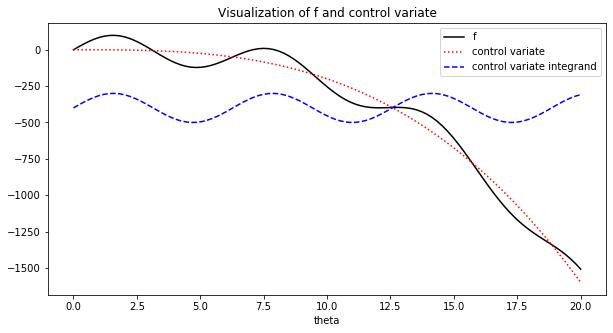

In [6]:
x = np.linspace(0, 20, 100)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, f(x), color='black', label='f')
ax.plot(x, h(x),linestyle=':', color='red', label='control variate')
ax.plot(x, control_mc(x), linestyle='--', color='blue', label='control variate integrand')
ax.set_title('Visualization of f and control variate')
ax.set_xlabel('theta')
ax.legend(loc='best')
plt.show()

## Example: Control Variates

In [7]:
print('variance of monte carlo estimate:', mc_variance)
print('variance of control variate monte carlo estimate:', control_mc_variance)

variance of monte carlo estimate: 2002.2389242017346
variance of control variate monte carlo estimate: 51.052475302251885


# Variance Reduction: Stratified Sampling

## The General Idea of Stratified Sampling
Again, based on our realization that "flat" functions have lower variance, we will try to partition the domain of $f$ into regions where $f$ is relatively "flat". We estimate the integral on each piece of the partition then sum over the pieces.

<img src="fig/strata.jpg" style="height:350px">

## The Stratified Sampling Monte Carlo Estimator

Fix a function $f(\theta)$, where $\theta$ is a random variable over the domain $\Theta$ whose pdf is $p(\theta|Y)$. Then the integral for $\mathbb{E}_{\theta|Y}[f(\theta)]$ can be decomposed as
$$
\mathbb{E}_{\theta|Y}[f(\theta)] = \int f(x)p(x) dx = \sum_{m=1}^M \int_{\Theta_m} f(\theta) p(\theta) d\theta
$$
where $\bigcup_{m=1}^M\Theta_m = \Theta$ and $\Theta_m \cap \Theta_{m'} = \emptyset$ if $m\neq m'$. 

To make $p(\theta)$ a pdf over $\Theta_{m'}$ we need to normalize it, i.e. 
$$
\frac{p(\theta)}{w_m},\quad w_m = \int_{\Theta_m} p(\theta)d\theta.
$$
We can then rewrite the integral for $\mathbb{E}_{\theta|Y}[f(\theta)]$ again
$$
\mathbb{E}_{\theta|Y}[f(\theta)] = \sum_{m=1}^M \int_{\Theta_m} w_m f(\theta) \left(\frac{p(\theta)}{w_m}\right) d\theta = \sum_{m=1}^M w_m \mathbb{E}_{\theta \sim \frac{p(\theta)}{w_m}\mathbb{1}_{\Theta_m}}[f(\theta)],
$$
where $\mathbb{1}_{\Theta_m}$ is the indicator function for the set $\Theta_m$. 

Fix a total sample size $S$. Let $\widehat{I}_m$ be the Monte Carlo estimate of $\mathbb{E}_{\theta \sim \frac{p(\theta)}{w_m}\mathbb{1}_{\Theta_m}}[f(\theta)]$ estimated with $S_m = w_m * S$ samples, the ***stratified sampling Monte Carlo estimator*** is
$$
\widehat{I}_{\text{SS}} = \sum_{m=1}^M w_m \widehat{I}_m.
$$
since $\mathrm{Var}\left[\widehat{I}_m\right]$ is lower than $\mathrm{Var}\left[\widehat{I}\right]$, we hope that $\mathrm{Var}\left[\widehat{I}_{\text{SS}}\right]$ is also lower.

## The Nitty Gritty of Stratified Sampling: Variance Reduction

The stratified sampling Monte Carlo is unbiased. Note that 

$$
\mathbb{E}_{\theta|Y}[f(\theta)] = \sum_{m=1}^M \mathbb{E}_{\theta \sim \frac{p(\theta)}{w_m}\mathbb{1}_{\Theta_m}}[f(\theta) | \text{strata}=m]\; \mathrm{Pr}[\text{strata}=m] =  \sum_{m=1}^M w_m\,\mathbb{E}_{\theta \sim \frac{p(\theta)}{w_m}\mathbb{1}_{\Theta_m}}[f(\theta) | \text{strata}=m].
$$

Since $\widehat{I}_m$ is an unbiased estimator of $\mathbb{E}_{\theta \sim \frac{p(\theta)}{w_m}\mathbb{1}_{\Theta_m}}[f(\theta) | \text{strata}=m]$, we have that 

$$
\mathbb{E}_{\theta|Y}\left[\widehat{I}_{\text{SS}}\right] = w_m \sum_{m=1}^M \mathbb{E}_{\theta \sim \frac{p(\theta)}{w_m}\mathbb{1}_{\Theta_m}}\left[\widehat{I}_m\right] = \mathbb{E}_{\theta|Y}[f(\theta)].
$$

The variance of $\widehat{I}_{\text{SS}}$ can be computed as

$$
\mathrm{Var}\left[\widehat{I}_{\text{SS}}\right] = \sum_{m=1}^M w_m^2\,\mathrm{Var}\left[ \widehat{I}_m \right] = \sum_{m=1}^M w_m^2 \frac{\sigma^2_m}{S_m},
$$

where $\sigma_m$ is the variance of $f(\theta)$ over $\Theta_m$. Again, conditioning on selecting the $m$-th stratum, we can show that 

$$
\mathrm{Var}\left[\widehat{I}\right] =  \mathrm{Var}\left[\widehat{I}_{\text{SS}}\right] + \frac{1}{S} \sum_{m=1}^M w_m\left(\mathbb{E}_{\theta \sim \frac{p(\theta)}{w_m}\mathbb{1}_{\Theta_m}}[f(\theta) | \text{strata}=m] - \mathbb{E}_{\theta|Y}[f(\theta)]\right)^2\geq \mathrm{Var}\left[\widehat{I}_{\text{SS}}\right],
$$

with equality holding only when the strata have identical mean.

## Example: Stratified Sampling
Again, let $f(\theta) = -0.2 \theta^3 + 100\sin(\theta)$ for $\theta|Y \sim U(0, 20)$. We aim to estimate:
$$
\mathbb{E}_{\theta|Y}[f(\theta)] = \int_{\Theta} f(\theta) p(\theta|Y) d\theta = \frac{1}{20} \int_{\Theta} f(\theta) d\theta.
$$

We compare the sample variance of $\widehat{I} = \frac{1}{S} \sum_{s=1}^S f(\theta_s)$ with that of the Monte Carlo estimate with stratified sampling: 

$$
\widehat{I}_{\text{SS}} = \sum_{m=1}^M \frac{1}{S_m} \sum_{s_m=1}^{S_m} w_m f(\theta_{s_m}),\; \theta_{s_m} \sim U(t_{m-1}, t_{m}),
$$

for sample sizes
$$
[13, 20, 9, 10, 15, 32],
$$

where the number $M$ of strata is 10, $w_m = \frac{t_m - t_{m-1}}{20}$, and where the end points of the strata is given by 

$$
[0, 2.75, 6.8, 8.6, 10.6, 13.6, 20.].
$$

## Example: Stratified Sampling

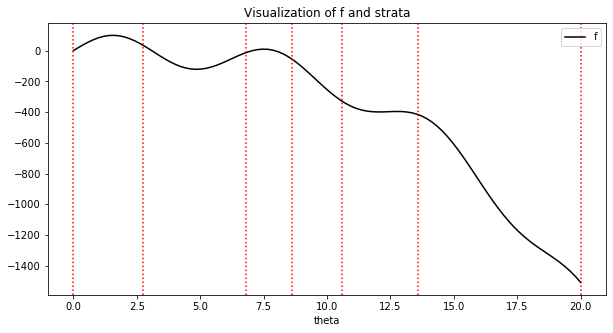

In [8]:
#define the end points of the strata
strata = [0, 2.75, 6.8, 8.6, 10.6, 13.6, 20.]
x = np.linspace(0, 20, 100)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, f(x), color='black', label='f')
for stratus in strata:
    ax.axvline(x=stratus, linestyle=':', color='red')
ax.set_title('Visualization of f and strata')
ax.set_xlabel('theta')
ax.legend(loc='best')
plt.show()

## Example: Stratified Sampling

In [14]:
#total number of trials to run (for computing variance of estimators)
total_trials = 500
#weights
w = [(strata[m + 1] - strata[m]) / 20. for m in range(len(strata) - 1)]
#sample sizes
S = [int(weight * 100) for weight in w]

stratified_estimates = []
monte_carlo = []

#repeat the estimate for many trials:
for i in range(total_trials):
    #compute the monte carlo estimate
    theta = np.random.uniform(0, 20, size=np.sum(S))
    monte_carlo.append(f(theta).mean())
    
    #compute the stratified sampling monte carlo estimate
    sum_over_strata = 0
    for m in range(len(strata) - 1):
        theta = np.random.uniform(strata[m], strata[m + 1], size=S[m])
        #compute the mc estimator for the mth stratus
        stratus_estimate = (w[m] * f(theta)).mean()
        sum_over_strata += stratus_estimate
        
    stratified_estimates.append(np.sum(sum_over_strata))

mc_variance = np.std(monte_carlo)**2
stratified_mc_variance = np.std(stratified_estimates)**2

In [13]:
print('variance of monte carlo estimate:', mc_variance)
print('variance of stratified monte carlo estimate:', stratified_mc_variance)

variance of monte carlo estimate: 1993.194946380082
variance of control variate monte carlo estimate: 368.9644656704295


# Variance Reduction: Importance Sampling

## The General Idea of Importance Sampling
The idea behind importance sampling is very similar to that of rejection sampling: we tackle the problem where the posterior $p(\theta|Y)$ is typically hard to sample from. Instead, 
1. we approximate $p(\theta|Y)$ with an easy distribution $q(\theta)$ and sample $\theta_1, \ldots, \theta_S$ from $q$. <br><br>
2. rather than rejecting some of the samples, we evaluate $f$ on all the samples, and then weight $f(\theta_s)$ based on how likely is $\theta_s$ to be from $p$ vs $q$. That is, we estimate $\mathbb{E}_{\theta|Y}[f(\theta)] \approx\frac{1}{S}\sum_{s=1}^S \frac{p(\theta_s|Y)}{q(\theta_s)}f(\theta_s)$, $\theta_s \sim q(\theta)$. **Why is this a good idea?**

<img src="fig/importance.jpg" style="height:300px">

## Variance of Importance Sampling

Fix a total sample size $S$. The ***importance sampling Monte Carlo estimator*** is
$$
\widehat{I}_{\text{IS}} = \frac{1}{S}\sum_{s=1}^S \frac{p(\theta_s|Y)}{q(\theta_s)}f(\theta_s).
$$
We call $q$ is the ***importance distribution***, $p$ the ***nominal distribution*** and $\frac{p(\theta_s|Y)}{q(\theta_s)}$ the ***importance weight***.

We can show that $\widehat{I}_{\text{IS}}$ is unbiased and consistent using the following fact (assuming $q$ and $p$ have the same support): 

$$
I = \mathbb{E}_{\theta \sim p(\theta|Y)}\left[f(\theta)\right] = \int_\Theta \frac{p(\theta|Y)}{q(\theta)}f(\theta) q(\theta) d\theta= \mathbb{E}_{\theta \sim q(\theta)}\left[\frac{p(\theta|Y)}{q(\theta)}f(\theta)\right].
$$

We can directly calculate the variance of $\widehat{I}_{\text{IS}}$ to be $\mathrm{Var}\left[\widehat{I}_{\text{IS}}\right] = \frac{\sigma^2_q}{S}$, 
where $\sigma^2_q$ is the variance of $\frac{p(\theta_s|Y)}{q(\theta_s)}f(\theta_s)$:

$$
\sigma^2_q = \int_\Theta f^2(\theta)p(\theta|Y)\frac{p(\theta|Y)}{q(\theta)} d\theta - I^2 = \int_\Theta\frac{\left(f(\theta)p(\theta|Y) - I q(\theta)\right)^2}{q(\theta)} d\theta.
$$

For comparison, $\mathrm{Var}\left[\widehat{I}\right] = \int_\Theta f(\theta)^2 p(\theta|Y)d\theta  - I^2$. So, we hope to get a variance reduction if $\frac{p(\theta|Y)}{q(\theta)} <1$ when $f(\theta)^2 p(\theta|Y)$ is large.

## The Nitty Gritty of Importance Sampling: the Design of $q$

1. **(When $q=0$)** if $q(\theta_0)=0$ but $p(\theta_0|Y) \neq 0$ for some $\theta_0$ then $\widehat{I}_{\text{IS}}$ will be biased, since sampling from $q$ can never simulate sampling from $p$ even after reweighting.<br><br>

2. **(When $q\approx 0$)** related, if $q(\theta_0)$ is very small (esp. when $q(\theta_0) < p(\theta_0|Y)$) then it is unlikely that your samples will include $\theta_0$. Hence, $\widehat{I}_{\text{IS}}$ will be biased. **If you've never see snow, you can't prepare for it!**<br><br>

3. **(Again, when $q\approx 0$)** recall that $\sigma^2_q = \int_\Theta\frac{\left(f(\theta)p(\theta|Y) - I q(\theta)\right)^2}{q(\theta)}$. For smaller $\sigma^2_q$, we want $\left(f(\theta)p(\theta|Y) - I q(\theta)\right)^2\approx 0$, i.e. $q\propto f(\theta)p(\theta|Y)$. But where $q(\theta) \approx 0$, $\sigma^2_q$ can be large even when $\left(f(\theta)p(\theta|Y) - I q(\theta)\right)^2$ is small.<br><br>

4. **(Heterogenous weights)** when $q$ and $p$ are very dissimlar, the weights will either be near 0 or huge. Say we have one sample with weight 0 and one with weight 999, how many samples are we effectively simulating from $p$? A way to measure the "quality" of the samples from $q$ in estimating $I$, is through the ***effective sample size***. 

  When we have $100$ samples from $q$ but ESS is 10, then essentially your IS estimate of $I$ is as good as as Monte Carlo estimate with 10 samples from $p$.

## Example: Importance Sampling

Again, let $f(\theta) = -0.2 \theta^3 + 100\sin(\theta)$ for $\theta|Y \sim U(0, 20)$. We aim to estimate:
$$
\mathbb{E}_{\theta|Y}[f(\theta)] = \int_{\Theta} f(\theta) p(\theta|Y) d\theta = \frac{1}{20} \int_{\Theta} f(\theta) d\theta.
$$

We compare the sample variance of $\widehat{I} = \frac{1}{S} \sum_{s=1}^S f(\theta_s)$ with that of the Monte Carlo estimate with importance sampling, with the importance distribution being $\mathcal{N}(12, 3)$:
$$
\widehat{I}_{\text{IS}} = \sum_{s=1}^S  \frac{1/20 * \mathbb{1}_{[0, 20]}}{\mathcal{N}(\theta_s; 12, 3)}\, f(\theta_{s}),\; \theta_{s} \sim \mathcal{N}(12, 3),
$$
for sample size $S=100$.

## Example: Importance Sampling

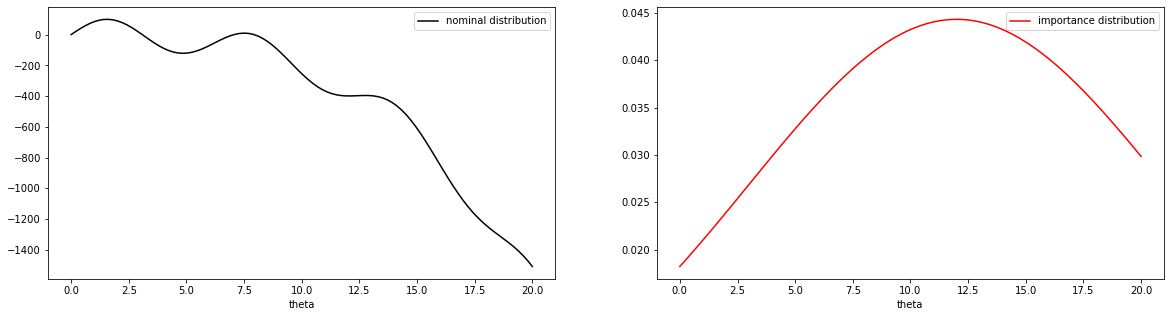

In [8]:
#normal pdf
normal = sp.stats.norm(loc=12, scale=3**2).pdf
#visualize nominal and importance distributions
x = np.linspace(0, 20, 100)
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(x, f(x), color='black', label='nominal distribution')
ax[0].set_xlabel('theta')
ax[0].legend(loc='best')
ax[1].plot(x, normal(x), color='red', label='importance distribution')
ax[1].set_xlabel('theta')
ax[1].legend(loc='best')
plt.show()

## Example: Importance Sampling

In [49]:
#total number of trials to run (for computing variance of estimators)
total_trials = 500
#sample sizes
S = 100

is_estimates = []
monte_carlo = []
importance_weights = []

#repeat the estimate for many trials:
for i in range(total_trials):
    #compute the monte carlo estimate
    #sample from p
    theta = np.random.uniform(0, 20, size=S)
    #evaluate f at samples of p
    monte_carlo.append(f(theta).mean())
    
    #compute the IS sampling monte carlo estimate
    #sample from importance distribution q
    theta = np.random.normal(12, 3, size=S)
    #compute importance weight of each sample
    weights = np.array([0 if (t < 0 or t > 20) else 1. / (20 * normal(t)) for t in theta])
    #count the number of weights that are zero (i.e. samples that are impossible under p)
    importance_weights.append(len(weights[weights==0]))
    #compute the IS estimate
    is_estimates.append((weights * f(theta)).mean())

mc_variance = np.std(monte_carlo)**2
is_mc_variance = np.std(is_estimates)**2

In [50]:
print('variance of monte carlo estimate:', mc_variance)
print('variance of IS monte carlo estimate:', is_mc_variance)

variance of monte carlo estimate: 2212.2325702371
variance of IS monte carlo estimate: 1364.0624019299828


In [51]:
print('average numnber of zero importance weight:', np.mean(importance_weights))

average numnber of zero importance weight: 0.37


# Application: Monte Carlo Estimation of Arbitrary Integrals

## Arbitrary Definite Integrals

We formulated Monte Carlo estimation as a way to approximate the expected value of functions of random variables. However, given a function of deterministic variables, $f(x)$, we can rewrite the integral

$$
\int_{\Omega} f(x) dx,
$$

where $x\in\mathbb{R}^D$ and $\Omega \subseteq \mathbb{R}^D$, like an expectation

$$
\int_{\Omega} f(x) dx = \int_{\Omega} g(x)h(x) dx,
$$

if we can factor $f$ as $f(x) = g(x)h(x)$.

The rewritten integral looks a lot like the expectation of $g(X)$ where the pdf of $X$ is $h(X)$. The only problem is that $h(x)$ is not necessarily a pdf!

## Rewriting an Arbitrary Definite Integral as an Expectation

We want to rewrite the following expression as an expectation:
$$
\int_{\Omega} f(x) dx = \int_{\Omega} g(x)h(x) dx.
$$
Let $V$ denote the integral of $h$ over $\Omega$:
$$
V = \int_{\Omega} h(x)dx.
$$
Note that, then, $\int_{\Omega} \frac{1}{V}h(x)dx = 1$. Hence, $\frac{1}{V}h(x)$ is a valid pdf over $\Omega$. 

Then we can write:
$$
\int_{\Omega} f(x) dx = \int_{\Omega} \left(Vg(x)\right)\left(\frac{1}{V}h(x)\right)dx.
$$

We recognize the above integral as an expectation, and hence can estimated using Monte Carlo methods:
$$
\mathbb{E}_{X\sim \frac{1}{V}h(X)}[Vg(X)] \approx V\sum_{s=1}^S g(X_s),\; X_s\sim \frac{1}{V}h(X).
$$

## How Do You Factor the Integrand $f$?

Once we factor $f(x)$ as $f(x) = g(x)h(x)$, then we can rewrite the integral of $f$ (over $\Omega$) as an expectation

$$
\int_{\Omega} f(x) dx = \int_{\Omega} \left(Vg(x)\right)\left(\frac{1}{V}h(x)\right)dx = \mathbb{E}_{X\sim \frac{1}{V}h(X)}[Vg(X)].
$$

But how does one choose $g$ and $h$? Two simple things to keep in mind:
1. since we need to sample from $h$, we need to choose $h$ such that it is easily approximated by distributions from which we know how to sample.
2. since the variance of the Monte Carlo estimator depends on $g$, we should choose $g$ to be relatively flat (so that the output of $g$ has low variance).

## Exercise: Monte Carlo Integration

Use Monte Carlo methods to estimate the following integral:

$$
\int_{0}^{1} \frac{3x^2}{x^3 - x^2 - 11x - 4} dx
$$

**Hint:** write the integrand $f$ as $f(x) = g(x)h(x)$ where $h(x)$ defines a pdf over $[0, 1]$ and is easy to sample from.